In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tqdm.auto import tqdm
import numpy as np
import pandas as pd

In [2]:
# Specify the path to your Excel file
excel_file_path = 'Desktop/fertility rates.xlsx'

# Read the first sheet into a DataFrame
df1 = pd.read_excel(excel_file_path, sheet_name='General Fertility')

# Read the second sheet into another DataFrame
df2 = pd.read_excel(excel_file_path, sheet_name='Total Fertility')

# Now, df_sheet1 and df_sheet2 contain the data from the respective sheets
print(df1)

                     Name  Value  Year   Indicator Id Indicator Type
0  General fertility rate    230  1989  FE_FRTR_W_GFR              I
1  General fertility rate    182  1993  FE_FRTR_W_GFR              I
2  General fertility rate    166  1998  FE_FRTR_W_GFR              I
3  General fertility rate    171  2003  FE_FRTR_W_GFR              I
4  General fertility rate    161  2008  FE_FRTR_W_GFR              I
5  General fertility rate    141  2014  FE_FRTR_W_GFR              I
6  General fertility rate    137  2015  FE_FRTR_W_GFR              I
7  General fertility rate    117  2020  FE_FRTR_W_GFR              I
8  General fertility rate    122  2022  FE_FRTR_W_GFR              I


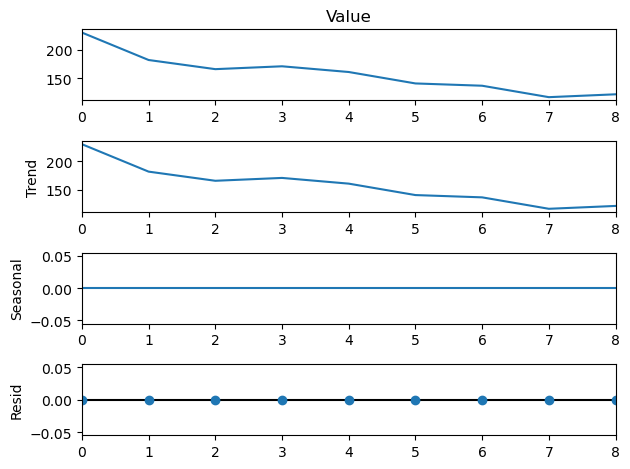

In [3]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
# Decompose to analyze trends
result = seasonal_decompose(df1['Value'],model = 'additive',period = 1)
result.plot()
plt.show()

In [4]:
from statsmodels.tsa.stattools import adfuller, kpss

In [5]:
# Test statistics
# Test stationarity for male life expectancy
stationarity_fertility = adfuller(df1['Value'])
adf_statistic = stationarity_fertility[0] 
p_value = stationarity_fertility[1]
print('Test statistic=',adf_statistic)
print('p_value =',p_value)

Test statistic= -0.1432266687174004
p_value = 0.9449591299047801


The p-value is greater than 0.05, indicating that the series is non-stationary and will require differencing to make it stationary before we can apply a forecasting model

In [6]:
from statsmodels.tsa.arima.model import ARIMA
# Difference the data to make it stationary
df1['Differenced'] = df1['Value'].diff().dropna()
#check if the differenced series is stationary
adf_result = adfuller(df1['Differenced'].dropna())

# fit an arima model
model = ARIMA(df1['Value'],order=[0,1,0])
model_fit = model.fit()
model_summary = model_fit.summary()

# forecast for the next 5 years
forecast = model_fit.forecast(steps=5)
forecast_years = np.arange(df1['Year'].iloc[-1]+1,df1['Year'].iloc[-1]+6)
forecast,forecast_years


(9     122.0
 10    122.0
 11    122.0
 12    122.0
 13    122.0
 Name: predicted_mean, dtype: float64,
 array([2023, 2024, 2025, 2026, 2027], dtype=int64))

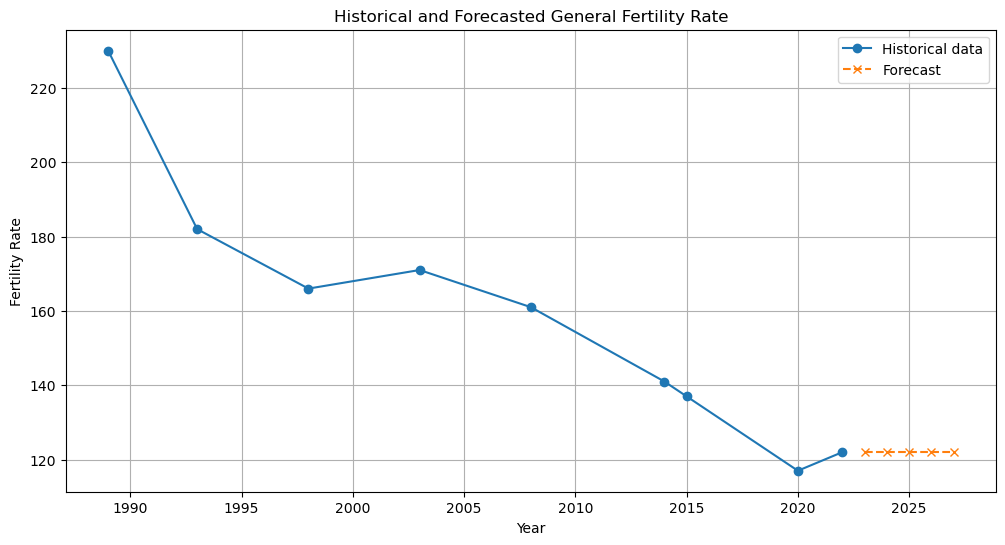

In [7]:
import seaborn as sns
#plotting the historical data along with the forecasted values
plt.figure(figsize=(12,6))
plt.plot(df1['Year'],df1['Value'],label ='Historical data',marker ='o')
plt.plot(forecast_years,forecast,label ='Forecast',marker ='x',linestyle='--')
plt.title('Historical and Forecasted General Fertility Rate')
plt.xlabel('Year')
plt.ylabel('Fertility Rate')
plt.legend()
plt.grid(True)

In [8]:
#summarizing forecasted data
fert_summary = pd.DataFrame({'Year':forecast_years,'Forecasted Fertility Rate':forecast})
fert_summary.set_index('Year',inplace=True)
fert_summary

,Forecasted Fertility Rate
Year,
2023,122.0
2024,122.0
2025,122.0
2026,122.0
2027,122.0


In [9]:
import numpy as np
import pandas as pd
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from math import sqrt

In [10]:
df1['Differenced']

0     NaN
1   -48.0
2   -16.0
3     5.0
4   -10.0
5   -20.0
6    -4.0
7   -20.0
8     5.0
Name: Differenced, dtype: float64

In [11]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")


# Split the data into training and testing sets
train_size = int(len(df1) * 0.8)
train, test = df1['Differenced'][0:train_size], df1['Differenced'][train_size:]

# Replace NaN values with the mean of the column
train = train.fillna(train.mean())

# Initialize variables to store the best model and its performance
best_model = None
best_rmse = float('inf')

# Define the range of p, d, q values for the grid search
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)

# Perform grid search to find the best ARIMA model
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            
            # Fit the ARIMA model
            model = auto_arima(train, start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=False, d=1, D=0, trace=False, suppress_warnings=True, stepwise=True)
            model.fit(train)

            # Make predictions on the test set
            predictions_diff = model.predict(n_periods=len(test))

            # Invert the differencing to get the original scale predictions
            predictions = np.cumsum(predictions_diff)

            # Calculate RMSE
            rmse = sqrt(mean_squared_error(df1['Value'][train_size:], predictions))

            # Update the best model if the current model has lower RMSE
            if rmse < best_rmse:
                best_rmse = rmse
                best_model = model

# Print the best model's parameters
print("Best ARIMA Model Parameters:", best_model.order)
print("RMSE:", rmse)
# Forecast future values using the best model
future_forecast_diff = best_model.predict(n_periods=len(test))
future_forecast = np.cumsum(future_forecast_diff)
print("Forecasted Values:", future_forecast)

Best ARIMA Model Parameters: (0, 1, 0)
RMSE: 125.58065137591858
Forecasted Values: 7   -4.0
8   -8.0
dtype: float64


In [12]:
# Split the data into training and testing sets
train_size = int(len(df1) * 0.8)
train, test = df1['Value'][0:train_size], df1['Value'][train_size:]
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit Exponential Smoothing model
model = ExponentialSmoothing(train)
fit_model = model.fit()

# Make predictions on the test set
predictions = fit_model.predict(start=len(train), end=len(train) + len(test) - 1)

# Calculate RMSE
rmse = sqrt(mean_squared_error(test, predictions))
print("Root Mean Squared Error (RMSE):", rmse)


Root Mean Squared Error (RMSE): 17.677669588669275


In [13]:
forecast1 = fit_model.forecast(steps=5)
forecast_years1 = np.arange(df1['Year'].iloc[-1]+1,df1['Year'].iloc[-1]+6)
# Display forecasted values for the next 5 years
forecast_df1 = pd.DataFrame({'Forecast values': forecast1,'Years':forecast_years1})
print("Forecasted Values for the Next 5 Years:")
print(forecast_df1)

Forecasted Values for the Next 5 Years:
    Forecast values  Years
7             137.0   2023
8             137.0   2024
9             137.0   2025
10            137.0   2026
11            137.0   2027


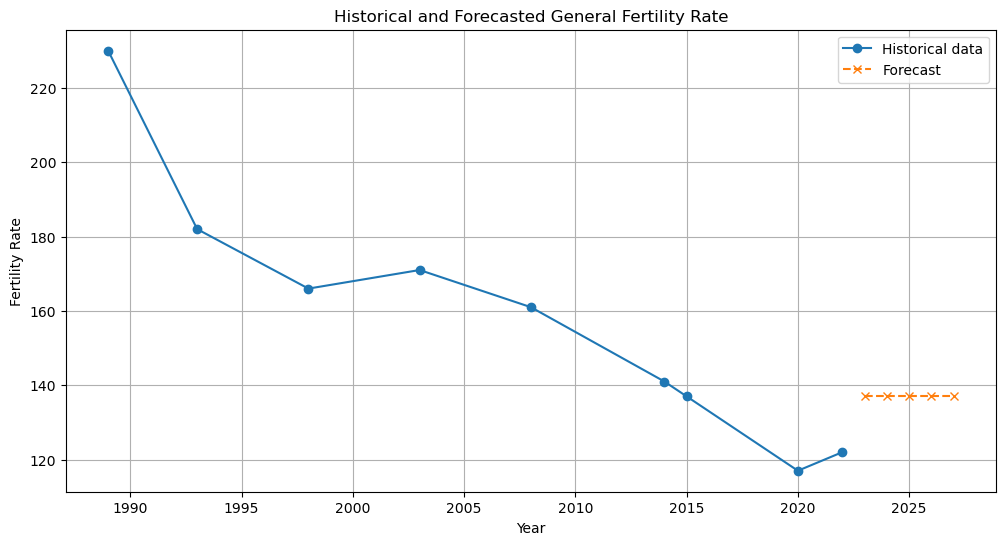

In [14]:
#plotting the historical data along with the forecasted values
plt.figure(figsize=(12,6))
plt.plot(df1['Year'],df1['Value'],label ='Historical data',marker ='o')
plt.plot(forecast_years1,forecast1,label ='Forecast',marker ='x',linestyle='--')
plt.title('Historical and Forecasted General Fertility Rate')
plt.xlabel('Year')
plt.ylabel('Fertility Rate')
plt.legend()
plt.grid(True)

In [16]:
df1.describe()

,Value,Year,Differenced
count,9.000000,9.000000,8.000000
mean,158.555556,2006.888889,-13.500000
std,34.832137,11.857956,17.188036
min,117.000000,1989.000000,-48.000000
25%,137.000000,1998.000000,-20.000000
50%,161.000000,2008.000000,-13.000000
75%,171.000000,2015.000000,-1.750000
max,230.000000,2022.000000,5.000000
